# Problem 2 - Policy and Value Iteration
---

In [59]:
import numpy as np
import matplotlib.pyplot as plt

## Util methods to represent the grid (do not modify)
#### You do not need modify any of these methods to complete Problem 2

In [60]:
# Maze state is represented as a 2-element NumPy array: (Y, X). Increasing Y is South.
grid = [
    'o.x.u',
    '..y..',
    '..y.*',
    '..z..']
topology = np.array([list(row) for row in grid])
flat_topology = topology.ravel()
rewards = {'.': 0, '*': 50, 'o': 4, 'u': 20, 'x': -10, 'y': -50,'z': -20}

row_count = len(grid) # 4
col_count = len(grid[0]) # 5
shape = (row_count, col_count) # (4, 5)

# Possible actions, expressed as (delta-y, delta-x)
directions="NSEW"
maze_actions = {
    'N': np.array([-1, 0]),
    'S': np.array([1, 0]),
    'E': np.array([0, 1]),
    'W': np.array([0, -1]),
}
actions = [maze_actions[direction] for direction in directions]


# Returns true if pos (y,x) is out of bounds
def is_wall(pos):
    (y, x) = pos
    return (y < 0 or y >= row_count or x < 0 or x >= col_count)

# Input is a flattened state, returns the reward at that state
def get_reward(state):
    assert (state in range(num_states)), f"get_reward: State was not an integer representing an in-bounds state ({state} was given)"
    return rewards.get(flat_topology[int(state)])

# Input is a flattened state, returns the unflattened representation of the state
def unflatten_index(flattened_index):
    return np.unravel_index(flattened_index, shape)

# Input state is an unflattened position and action is an index into the actions[] array
# Returns a tuple containing the new position of taking the action from the state
def move(state, action):
    return tuple((state + actions[action]).reshape(1, -1)[0])

# Returns an array of the "side states" when taking action beginning at unflattened position state
# Does not return states which are out of bounds
def get_side_states(action, state):
    side_states = []
    
    if action == 0 or action == 1:
        if not is_wall(move(state, 3)):
            side_states.append(move(state, 3))
        if not is_wall(move(state, 2)):
            side_states.append(move(state, 2))
    elif action == 2 or action == 3:
        if not is_wall(move(state, 0)):
            side_states.append(move(state, 0))
        if not is_wall(move(state, 1)):
            side_states.append(move(state, 1))
            
    return side_states
    
# Inputs s1, s2 are flattened states, action represents an index into the actions array
# Returns p(s2 | s1, action)
def get_transition_prob(s1, action, s2):
    # Check the inputs are valid
    assert (action in [0,1,2,3]), f"get_transition_prob: Action needs to be an integer in [0,1,2,3], but {action} was given"
    assert (s1 in range(num_states)), f"get_transition_prob: Input s1 was not an integer representing an in-bounds state ({s1} was given)"
    assert (s2 in range(num_states)), f"get_transition_prob: Input s2 was not an integer representing an in-bounds state ({s2} was given)"
    
    state1 = unflatten_index(int(s1))
    state2 = unflatten_index(int(s2))
    action = int(action)

    new_state = move(state1, action)

    sstates = get_side_states(action, state1)
    succeed_prb = 0.8
    slip_prb = 0.1

    # One of the side states was a wall: adjust probabilities accordingly.
    if len(sstates) == 1:
        succeed_prb = 0.9

    if is_wall(new_state):
        if(state1 == state2):
            return succeed_prb
    else:
        if(state2 == new_state):
            return succeed_prb

    # Oherwise, check if state2 is on either side
    for side_state in sstates:
        if(state2 == side_state):
            return slip_prb

    return 0.

In [61]:
# MAKE PLOTS (do not modify)

# Util to draw the value function V as numbers on a plot.
def make_value_plot(V):
    # Useful stats for the plot
    value_function = np.reshape(V, shape)

    # Write the value on top of each square
    indx, indy = np.arange(row_count), np.arange(col_count)

    fig, ax = plt.subplots()
    ax.imshow(value_function, interpolation='none', cmap= plt.get_cmap('coolwarm_r'))

    for s in range(len(V)):
        val = V[s]
        (xval, yval) = unflatten_index(s)
        t = "%.2f"%(val,) # format value with 1 decimal point
        ax.text(yval, xval, t, color='black', va='center', ha='center', size=15)
        

# Util to draw the policy pi as arrows on a plot.
def make_policy_plot(pi, iter_type, iter_num):
    # Useful stats for the plot
    row_count = len(grid)
    col_count = len(grid[0])
    policy_function = np.reshape(pi, shape)

    for row in range(row_count):
        for col in range(col_count):
            if policy_function[row,col] == 0:
                dx = 0; dy = -.5
            if policy_function[row,col] == 1:
                dx = 0; dy = .5
            if policy_function[row,col] == 2:
                dx = .5; dy = 0
            if policy_function[row,col] == 3:
                dx = -.5; dy = 0
            plt.arrow( col , row , dx , dy , shape='full', fc='w' , ec='gray' , lw=1., length_includes_head=True, head_width=.1 )
    plt.title(iter_type + ' Iteration, i = ' + str(iter_num))
    plt.savefig(iter_type + '_' + str(iter_num) + '.png')
    plt.show()

In [62]:
np.random.seed(181)
VALUE_ITER = 'Value'
POLICY_ITER = 'Policy'

num_states = shape[0] * shape[1] # num_states = 20
num_actions = len(actions) # num_actions = 4

# Problem Description
Below you will implement policy and value iteration.

A state is represented as an integer from ``0`` to ``num_states - 1``
<br>
An action is represented as an integer in ``[0,1,2,3]``, which represents the four cardinal directions [N,S,E,W]

Each state has a reward associated with it. The agent gains the reward of a state when it takes an action at that state, not immediately upon entry.

``pi`` contains the learned policy at each state, represented by an array of length ``num_states``. In this exercise we will be implementing a deterministic policy, so each state has exactly one action associated with it.
<br>
ex: [2, 3, 1, 1, 2, 0, 1, 2, 2, 1, 3, 0, 0, 2, 2, 1, 3, 3, 2, 0]

``V`` represents the learned value function at each state. Like the above, it is also represented as an array of length ``num_states`` where the entry at index ``i`` represents the value of state ``i``.


## Helper methods

Recall that when you take an action in Gridworld, you won't always necessarily move in that direction. Instead there is some probability of moving to a state on either side. You do not need to calculate these transition probabilities yourself. Please use the helper functions ``get_transition_prob`` and ``get_reward`` in this file. The method headers are listed below:

``get_reward(state):`` Input is a state, output is the reward at that state

``get_transition_prob(s1, a, s2):`` Returns the probability of transitioning from state ``s1`` to state ``s2`` upon taking action ``a``.

An example is given below:

In [63]:
# Example usage
print(get_reward(14))
print(get_transition_prob(16, 0, 11))

50
0.8


## 1a) Policy Evaluation

Returns array ``V`` representing the value of policy ``pi`` using discount factor ``gamma``

Note: You can do this either closed-form or iteratively. If performed iteratively, please use a convergence tolerance of at least ``0.0001``

In [64]:
# Solution (iterative)
def policy_evaluation(pi, gamma):
    theta = 0.0001
    # Start with a random (all 0) value function
    V = np.zeros(num_states)

    while True:
        delta = 0
        for s in range(num_states):
            v = V[s]
            a = int(pi[s])
            # new value based on this action
            new_value = 0
            for s_prime in range(num_states):
                transition_prob = get_transition_prob(s, a, s_prime)
                if transition_prob > 0:  # Only consider possible transitions
                    new_value += transition_prob * (get_reward(s) + gamma * V[s_prime])
            
            V[s] = new_value
            delta = max(delta, abs(v - V[s]))
        
        if delta < theta:
            break
    
    return V

## 1b) Policy Iteration

Now that we have ``V`` computed in 1a), perform **one step** of policy iteration to return the updated policy ``pi_new``

In [65]:
def update_policy_iteration(V, gamma):
    pi_new = np.zeros(num_states)
    
    for s in range(num_states):
        action_values = np.zeros(num_actions)
        for a in range(num_actions):
            for s_prime in range(num_states):
                transition_prob = get_transition_prob(s, a, s_prime)
                if transition_prob > 0: 
                    action_values[a] += transition_prob * (get_reward(s) + gamma * V[s_prime])
        
        pi_new[s] = np.argmax(action_values)
    
    return pi_new

## 2) Value Iteration
Given a value function ``V``, perform **one step** of value iteration and return the updated ``V_new`` and corresponding ``pi_new``

In [66]:
def update_value_iteration(V, gamma):
    V_new = np.zeros(num_states)
    pi_new = np.zeros(num_states)

    for s in range(num_states):
        action_values = np.zeros(num_actions)
        for a in range(num_actions):
            for s_prime in range(num_states):
                transition_prob = get_transition_prob(s, a, s_prime)
                if transition_prob > 0: 
                    action_values[a] += transition_prob * (get_reward(s) + gamma * V[s_prime])
        
        V_new[s] = np.max(action_values)
        pi_new[s] = np.argmax(action_values)
    
    return V_new, pi_new

# Run code, plot results

The ``learn_strategy`` method iteratively runs the one-step methods you wrote in parts 1 and 2, either until the value function converges under <TT>ct</TT> or until a specified number of iterations <TT>max_iter</TT> have elapsed. It will also print out intermediate plots of the learned policy and value function at intervals of <TT>print_every</TT>. The arguments of the function are listed in more detail below:

``planning_type`` (<TT>string</TT>): 
    Specifies whether value or policy iteration is used to learn the strategy.
    
``max_iter`` (<TT>int</TT>):
    The maximum number of iterations (i.e. number of updates) the learning
    policy will be run for.
    
``print_every`` (<TT>int</TT>):
    The frequency at which the function will print value and policy plots.
    
``ct`` (<TT>float</TT>):
    The convergence tolerance used for policy or value iteration.
    
``gamma`` (<TT>float</TT>):
    The discount factor.

In [67]:
# Do not modify the learn_strategy method, but read through its code
def learn_strategy(planning_type = VALUE_ITER, max_iter = 10, print_every = 5, ct = None, gamma = 0.7):
    # Loop over some number of episodes
    V = np.zeros(num_states)
    pi = np.zeros(num_states)

    # Update Q-table using value/policy iteration until max iterations or until ct reached
    for n_iter in range(max_iter):
        V_prev = V.copy()

        # Update V and pi using value or policy iteration.
        if planning_type == VALUE_ITER:
            V, pi = update_value_iteration(V, gamma)
        elif planning_type == POLICY_ITER:
            V = policy_evaluation(pi, gamma)
            pi = update_policy_iteration(V, gamma)
        
        # Calculate the difference between this V and the previous V
        diff = np.absolute(np.subtract(V, V_prev))

        # Check that every state's difference is less than the convergence tol
        if ct and np.max(diff) < ct:
            make_value_plot(V = V)
            make_policy_plot(pi = pi, iter_type = planning_type, iter_num = n_iter+1)
            print("Converged at iteration " + str(n_iter+1))
            return 0

        # Make value plot and plot the policy
        if (n_iter % print_every == 0):
            make_value_plot(V = V)
            make_policy_plot(pi = pi, iter_type = planning_type, iter_num = n_iter+1)

## Show Policy Iteration

Beginning policy iteration.


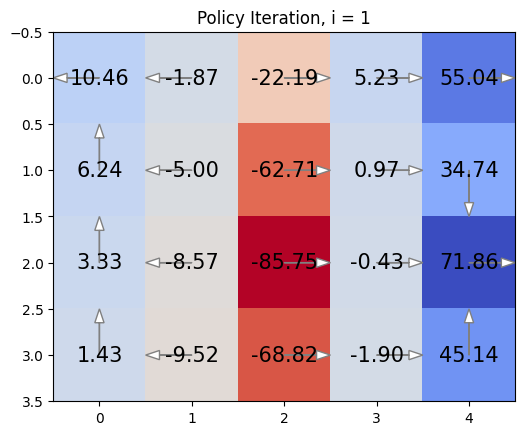

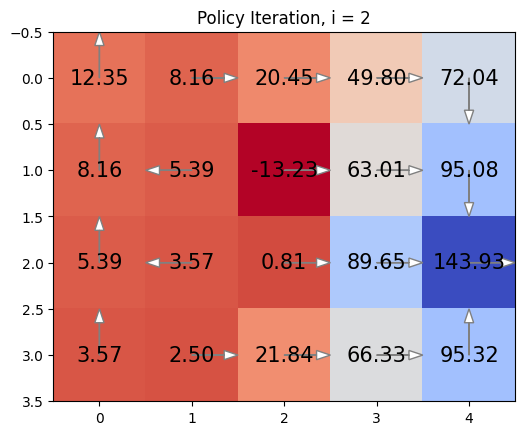

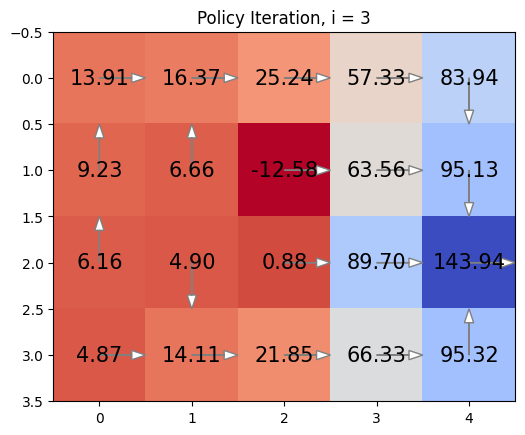

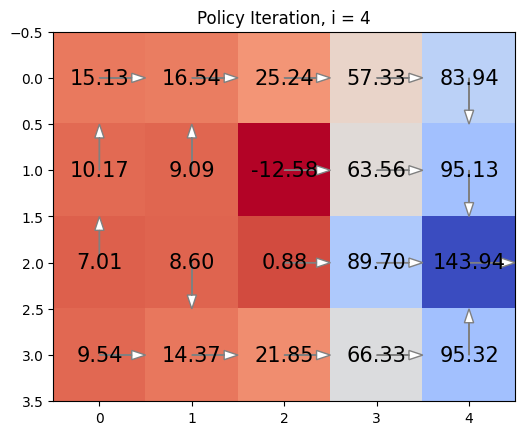

Policy iteration complete.



In [68]:
print('Beginning policy iteration.')
learn_strategy(planning_type=POLICY_ITER, max_iter = 4, print_every = 1, ct = 0.01, gamma = 0.7)
print('Policy iteration complete.\n')

## Show Value Iteration

Beginning value iteration.


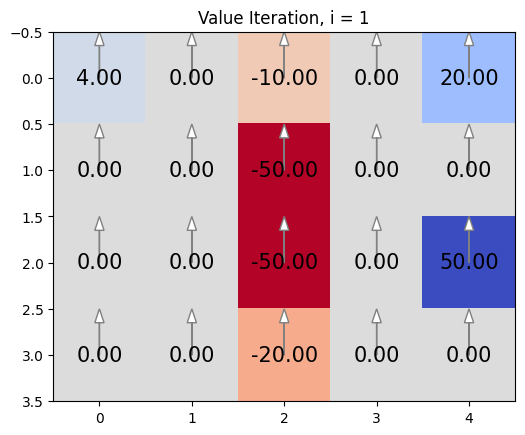

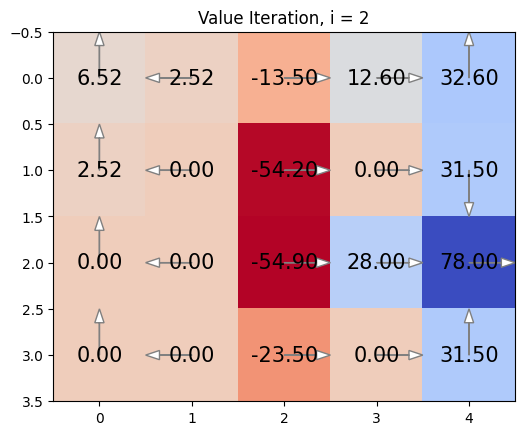

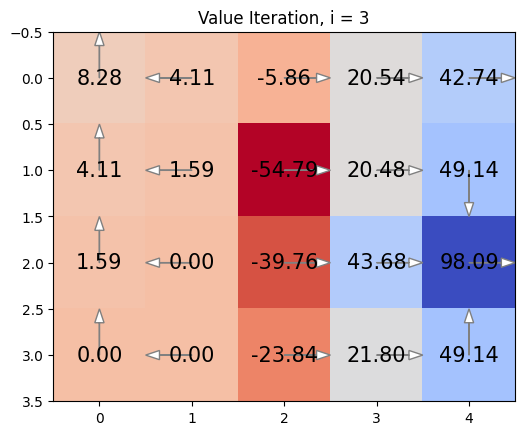

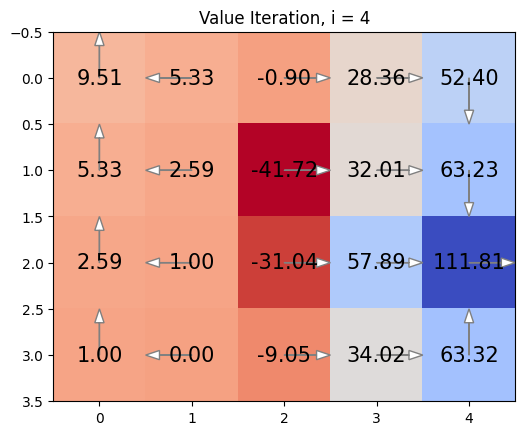

Value iteration complete.



In [69]:
print('Beginning value iteration.')
learn_strategy(planning_type=VALUE_ITER, max_iter = 4, print_every = 1, ct = 0.01, gamma = 0.7)
print('Value iteration complete.\n')

# Problem 3 

Make sure to install pygame (i.e. through running `pip install pygame`)

In [70]:
!pip install -q pygame

In [71]:
import numpy as np
import numpy.random as npr
import pygame as pg

# # uncomment this for animation
# from p3src.SwingyMonkey import SwingyMonkey

# uncomment this for no animation (use this for most purposes! it gets very slow otherwise)
from p3src.SwingyMonkeyNoAnimation import SwingyMonkey

In [72]:
# Some constants. Don't edit this!
X_BINSIZE = 200
Y_BINSIZE = 100
X_SCREEN = 1400
Y_SCREEN = 900

In [122]:
class RandomJumper(object):
    """
    This agent jumps randomly.
    """

    def __init__(self):
        self.last_state = None
        self.last_action = None
        self.last_reward = None

        # We initialize our Q-value grid that has an entry for each action and state.
        # (action, rel_x, rel_y)
        self.Q = np.zeros((2, X_SCREEN // X_BINSIZE, Y_SCREEN // Y_BINSIZE))

    def reset(self):
        self.last_state = None
        self.last_action = None
        self.last_reward = None

    def discretize_state(self, state):
        """
        Discretize the position space to produce binned features.
        rel_x = the binned relative horizontal distance between the monkey and the tree
        rel_y = the binned relative vertical distance between the monkey and the tree
        """

        rel_x = int((state["tree"]["dist"]) // X_BINSIZE)
        rel_y = int((state["tree"]["top"] - state["monkey"]["top"]) // Y_BINSIZE)
        return (rel_x, rel_y)

    def action_callback(self, state):
        """
        Implement this function to learn things and take actions.
        Return 0 if you don't want to jump and 1 if you do.
        """

        new_action = npr.rand() < 0.1
        new_state = state

        self.last_action = new_action
        self.last_state = new_state

        return self.last_action

    def reward_callback(self, reward):
        """This gets called so you can see what reward you get."""

        self.last_reward = reward

In [269]:
# this code block is for learnign the best hyper parameters for the learner

import numpy as np
import numpy.random as npr
import pygame as pg
from itertools import product

# From p3src.SwingyMonkeyNoAnimation import SwingyMonkey

class Learner(object):
    '''
    This agent uses Q-learning with velocity-aware state!
    '''

    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.1, 
                 vel_bins=15, vel_range=50, decaying_epsilon=True):
        self.last_state = None
        self.last_action = None
        self.last_reward = None
        
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.initial_epsilon = epsilon
        self.decaying_epsilon = decaying_epsilon
        self.episode = 0
        
        # Velocity parameters
        self.vel_bins = vel_bins
        self.vel_range = vel_range
        
        # Q-table now includes velocity dimension
        self.Q = np.zeros((2, X_SCREEN // X_BINSIZE, Y_SCREEN // Y_BINSIZE, self.vel_bins))
    
    def reset(self):
        self.last_state = None
        self.last_action = None
        self.last_reward = None
        self.episode += 1
        
        # Decaying epsilon
        if self.decaying_epsilon:
            self.epsilon = self.initial_epsilon / (1 + 0.05 * self.episode)
    
    def discretize_state(self, state):
        rel_x = int((state["tree"]["dist"]) // X_BINSIZE)
        rel_y = int((state["tree"]["top"] - state["monkey"]["top"]) // Y_BINSIZE)
        
        # Discretize velocity
        velocity = state["monkey"]["vel"]
        vel_bin = int((velocity + self.vel_range / 2) / self.vel_range * self.vel_bins)
        vel_bin = max(0, min(vel_bin, self.vel_bins - 1))
        
        return (rel_x, rel_y, vel_bin)

    def action_callback(self, state):
        current_state = self.discretize_state(state)
        
        if self.last_state is not None and self.last_action is not None and self.last_reward is not None:
            # Update Q-value with velocity dimension
            max_Q = np.max(self.Q[:, current_state[0], current_state[1], current_state[2]])
            self.Q[self.last_action, self.last_state[0], self.last_state[1], self.last_state[2]] += self.alpha * (
                self.last_reward + self.gamma * max_Q - 
                self.Q[self.last_action, self.last_state[0], self.last_state[1], self.last_state[2]]
            )
        
        if npr.rand() < self.epsilon:
            new_action = npr.randint(0, 2)
        else:
            new_action = np.argmax(self.Q[:, current_state[0], current_state[1], current_state[2]])
        
        self.last_action = new_action
        self.last_state = current_state
        
        return self.last_action
    
    def reward_callback(self, reward):
        self.last_reward = reward


class HyperparameterOptimizer:
    def __init__(self):
        # Define hyperparameter search space
        self.param_ranges = {
            'alpha': [0.05, 0.1, 0.2, 0.3],
            'gamma': [0.8, 0.9, 0.95, 0.99],
            'epsilon': [0.05, 0.1, 0.2],
            'vel_bins': [10, 15, 20],
            'vel_range': [40, 50, 60],
            'decaying_epsilon': [True, False]
        }
    
    def run_experiment(self, params, n_episodes=50):
        """Run experiment with given parameters and return performance metrics"""
        agent = Learner(**params)
        hist = []
        
        for ii in range(n_episodes):
            swing = SwingyMonkey(sound=False,
                               text=f"Param Test Epoch {ii}",
                               tick_length=10,
                               action_callback=agent.action_callback,
                               reward_callback=agent.reward_callback)
            
            while swing.game_loop():
                pass
            
            hist.append(swing.score)
            agent.reset()
        
        pg.quit()
        
        # Calculate performance metrics
        metrics = {
            'mean_score': np.mean(hist),
            'max_score': np.max(hist),
            'last_10_mean': np.mean(hist[-10:]),
            'first_50_idx': next((i for i, x in enumerate(hist) if x > 50), n_episodes)
        }
        
        return metrics, hist
    
    def grid_search(self, n_trials_per_config=3, n_episodes_per_trial=50):
        """Perform grid search over parameter space"""
        best_params = None
        best_score = -float('inf')
        results = []
        
        # Create all parameter combinations
        keys = list(self.param_ranges.keys())
        values = list(self.param_ranges.values())
        
        # For efficiency, let's sample rather than full grid search
        max_combinations = 100
        all_combinations = list(product(*values))
        
        if len(all_combinations) > max_combinations:
            selected_combinations = np.random.choice(
                len(all_combinations), 
                max_combinations, 
                replace=False
            )
            combinations = [all_combinations[i] for i in selected_combinations]
        else:
            combinations = all_combinations
        
        for i, combo in enumerate(combinations):
            params = dict(zip(keys, combo))
            print(f"\nTesting params {i+1}/{len(combinations)}: {params}")
            
            trial_metrics = []
            for trial in range(n_trials_per_config):
                metrics, hist = self.run_experiment(params, n_episodes_per_trial)
                trial_metrics.append(metrics)
                
            # Average metrics across trials
            avg_metrics = {
                'mean_score': np.mean([m['mean_score'] for m in trial_metrics]),
                'max_score': np.max([m['max_score'] for m in trial_metrics]),
                'last_10_mean': np.mean([m['last_10_mean'] for m in trial_metrics]),
                'first_50_idx': np.mean([m['first_50_idx'] for m in trial_metrics])
            }
            
            # Use a composite score for ranking
            composite_score = (avg_metrics['mean_score'] + 
                             avg_metrics['last_10_mean'] * 2 + 
                             avg_metrics['max_score'] * 0.5)
            
            results.append({
                'params': params,
                'metrics': avg_metrics,
                'composite_score': composite_score
            })
            
            if composite_score > best_score:
                best_score = composite_score
                best_params = params
                print(f"New best score: {composite_score:.2f}")
        
        return best_params, results
    
    def find_best_hyperparameters(self):
        """Main method to run hyperparameter optimization"""
        best_params, results = self.grid_search(n_trials_per_config=2, n_episodes_per_trial=50)
        
        # Sort results by composite score
        results.sort(key=lambda x: x['composite_score'], reverse=True)
        
        return best_params


# Main execution code
if __name__ == "__main__":
    # Step 1: Find best hyperparameters
    optimizer = HyperparameterOptimizer()
    best_params = optimizer.find_best_hyperparameters()
    
    print(f"Best parameters: {best_params}")


Testing params 1/100: {'alpha': 0.2, 'gamma': 0.99, 'epsilon': 0.1, 'vel_bins': 20, 'vel_range': 50, 'decaying_epsilon': False}
New best score: 3.59

Testing params 2/100: {'alpha': 0.05, 'gamma': 0.99, 'epsilon': 0.1, 'vel_bins': 15, 'vel_range': 60, 'decaying_epsilon': True}
New best score: 4.71

Testing params 3/100: {'alpha': 0.05, 'gamma': 0.95, 'epsilon': 0.05, 'vel_bins': 10, 'vel_range': 40, 'decaying_epsilon': True}
New best score: 6.26

Testing params 4/100: {'alpha': 0.05, 'gamma': 0.8, 'epsilon': 0.2, 'vel_bins': 15, 'vel_range': 40, 'decaying_epsilon': True}

Testing params 5/100: {'alpha': 0.1, 'gamma': 0.95, 'epsilon': 0.1, 'vel_bins': 10, 'vel_range': 60, 'decaying_epsilon': False}

Testing params 6/100: {'alpha': 0.2, 'gamma': 0.99, 'epsilon': 0.1, 'vel_bins': 20, 'vel_range': 50, 'decaying_epsilon': True}
New best score: 7.32

Testing params 7/100: {'alpha': 0.1, 'gamma': 0.8, 'epsilon': 0.1, 'vel_bins': 20, 'vel_range': 40, 'decaying_epsilon': False}

Testing params

In [ ]:
class Learner(object):
    """
    optimized hyperparameters:
      - alpha = 0.2
      - gamma = 0.99
      - epsilon = 0.05 
      - vel_bins = 20
      - vel_range = 40
      - decaying_epsilon = True (epsilon decays by epsilon_decay each step)
    """

    def __init__(self):
        self.last_state = None
        self.last_action = None
        self.last_reward = None

        self.alpha = 0.2          
        self.gamma = 0.99         
        self.epsilon = 0.05       
        self.decaying_epsilon = True
        self.epsilon_decay = 0.99

        self.vel_bins = 20
        self.vel_range = 40

        self.Q = np.zeros((
            2,
            X_SCREEN // X_BINSIZE,
            Y_SCREEN // Y_BINSIZE,
            self.vel_bins
        ))

    def reset(self):
        """Reset history between episodes."""
        self.last_state = None
        self.last_action = None
        self.last_reward = None

    def discretize_state(self, state):
        """
        Discretize the continuous state into (x_bin, y_bin, vel_bin).
        """
        rel_x = int(state["tree"]["dist"] // X_BINSIZE)
        rel_y = int((state["tree"]["top"] - state["monkey"]["top"]) // Y_BINSIZE)

        velocity = state["monkey"]["vel"]
        vel_bin = int((velocity + self.vel_range / 2)
                      / self.vel_range * self.vel_bins)
        vel_bin = max(0, min(vel_bin, self.vel_bins - 1))

        return (rel_x, rel_y, vel_bin)

    def action_callback(self, state):
        """
        Decide on an action given the current state, and update Q after seeing
        reward from the last action.
        """
        current_state = self.discretize_state(state)

        # Perform Q-learning update for the previous step
        if (self.last_state is not None
                and self.last_action is not None
                and self.last_reward is not None):
            old_q = self.Q[
                self.last_action,
                self.last_state[0],
                self.last_state[1],
                self.last_state[2]
            ]
            future_max = np.max(
                self.Q[:, current_state[0], current_state[1], current_state[2]]
            )
            self.Q[
                self.last_action,
                self.last_state[0],
                self.last_state[1],
                self.last_state[2]
            ] = old_q + self.alpha * (
                self.last_reward + self.gamma * future_max - old_q
            )

        # Epsilon-greedy action selection
        if npr.rand() < self.epsilon:
            new_action = npr.randint(0, 2)
        else:
            new_action = int(np.argmax(
                self.Q[:, current_state[0], current_state[1], current_state[2]]
            ))

        # Decay epsilon if enabled
        if self.decaying_epsilon:
            self.epsilon *= self.epsilon_decay

        # Save for next update
        self.last_action = new_action
        self.last_state = current_state

        return new_action

    def reward_callback(self, reward):
        """
        Receive the reward for the last action.
        """
        self.last_reward = reward


In [246]:
def run_games(learner, hist, iters=100, t_len=100):
    """
    Driver function to simulate learning by having the agent play a sequence of games.
    """
    for ii in range(iters):
        # Make a new monkey object.
        swing = SwingyMonkey(sound=False,  # Don't play sounds.
                             text="Epoch %d" % (ii),  # Display the epoch on screen.
                             tick_length=t_len,  # Make game ticks super fast.
                             action_callback=learner.action_callback,
                             reward_callback=learner.reward_callback)

        # Loop until you hit something.
        while swing.game_loop():
            pass

        # Save score history.
        hist.append(swing.score)

        # Reset the state of the learner.
        learner.reset()
    pg.quit()
    return

In [267]:
# Uncomment the agent you want to run.
# agent = RandomJumper()
agent = Learner()

# Empty list to save history.
hist = []

# Run games. You can update t_len to be smaller to run it faster.
run_games(agent, hist, 100, 20)  
print(hist)

# Save history. 
np.save('hist', np.array(hist))
print(f"Max score: {max(hist)}")
print(f"Average last 20 epochs: {np.mean(hist[-20:])}")
print(f"First score > 50: {next((i for i, x in enumerate(hist) if x > 50), 'Never')}")

[0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 6, 1, 1, 1, 0, 1, 1, 3, 9, 0, 1, 6, 2, 8, 3, 31, 1, 5, 10, 14, 10, 25, 47, 14, 8, 1, 38, 12, 12, 0, 0, 24, 0, 3, 6, 0, 29, 53, 0, 0, 0, 0, 0, 0, 6, 0, 0, 1, 0, 1, 2, 0, 1, 11, 2, 31, 2, 0, 2, 2, 6, 3, 0, 0, 2, 1, 0, 1, 9, 1, 4, 1, 0, 0, 1, 0, 3, 1, 0, 1, 0, 1, 1, 1, 0, 3, 0, 1]
Max score: 53
Average last 20 epochs: 1.4
First score > 50: 49



Testing params 1/100: {'alpha': 0.2, 'gamma': 0.95, 'epsilon': 0.05, 'vel_bins': 20, 'vel_range': 40, 'decaying_epsilon': False}
New best score: 6.63

Testing params 2/100: {'alpha': 0.05, 'gamma': 0.9, 'epsilon': 0.05, 'vel_bins': 10, 'vel_range': 50, 'decaying_epsilon': False}
New best score: 7.79

Testing params 3/100: {'alpha': 0.3, 'gamma': 0.9, 'epsilon': 0.2, 'vel_bins': 10, 'vel_range': 50, 'decaying_epsilon': True}

Testing params 4/100: {'alpha': 0.3, 'gamma': 0.99, 'epsilon': 0.2, 'vel_bins': 10, 'vel_range': 40, 'decaying_epsilon': False}

Testing params 5/100: {'alpha': 0.3, 'gamma': 0.9, 'epsilon': 0.1, 'vel_bins': 15, 'vel_range': 40, 'decaying_epsilon': False}

Testing params 6/100: {'alpha': 0.05, 'gamma': 0.8, 'epsilon': 0.05, 'vel_bins': 15, 'vel_range': 50, 'decaying_epsilon': False}
New best score: 8.44

Testing params 7/100: {'alpha': 0.05, 'gamma': 0.95, 'epsilon': 0.2, 'vel_bins': 20, 'vel_range': 40, 'decaying_epsilon': False}

Testing params 8/100: {'alpha': 

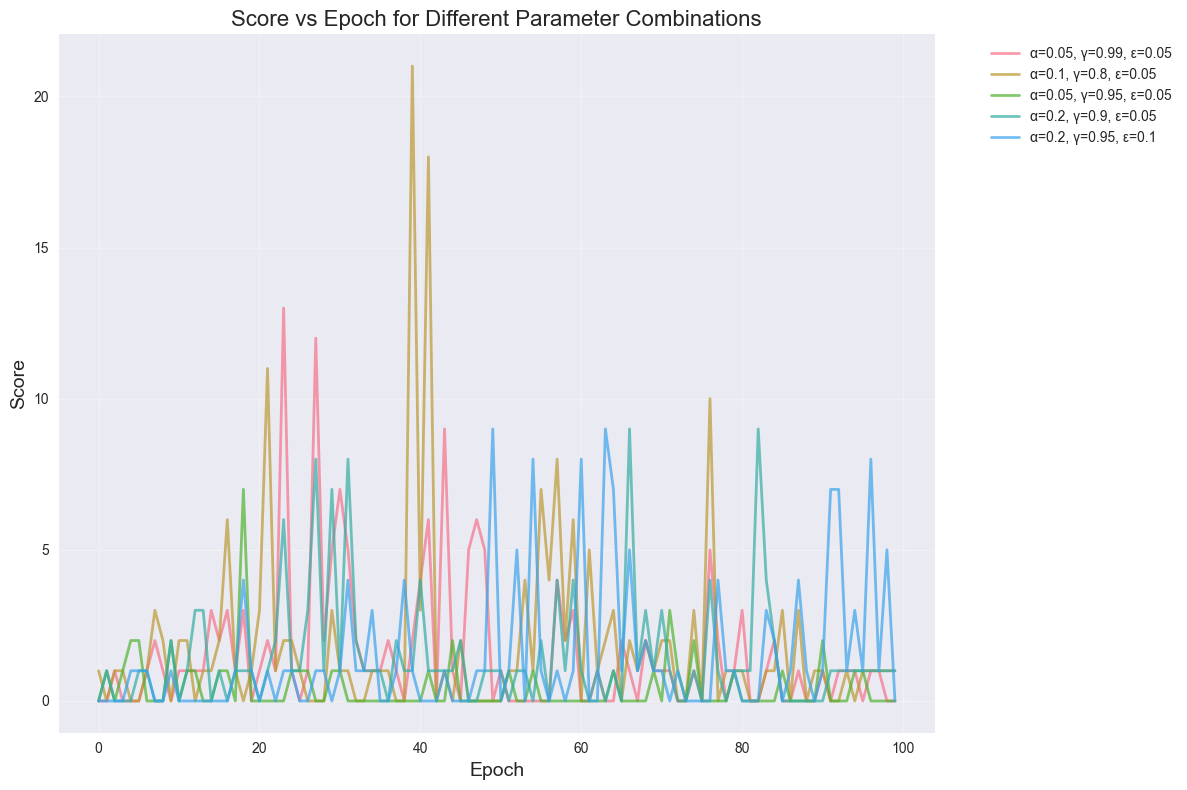

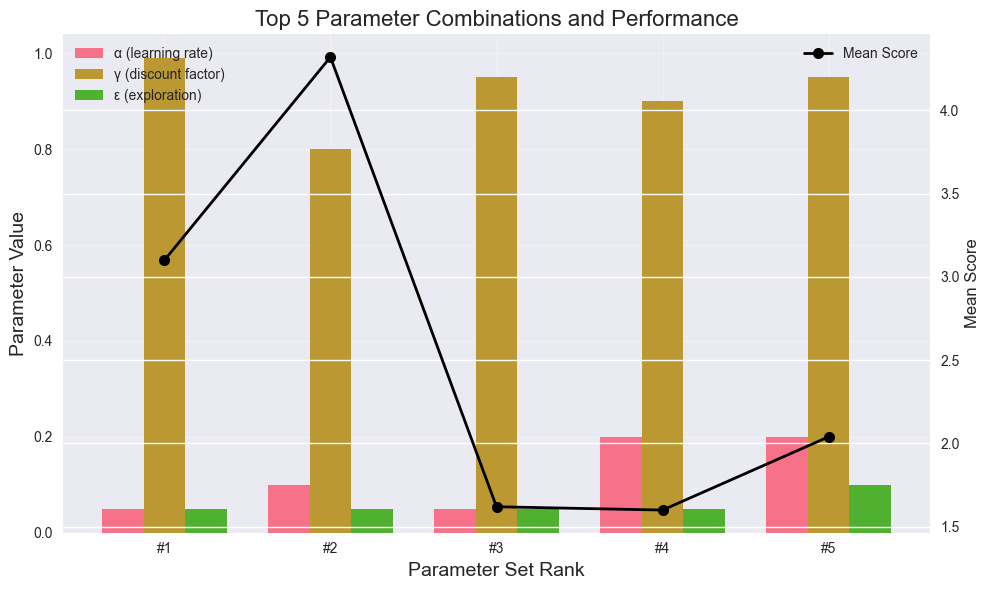

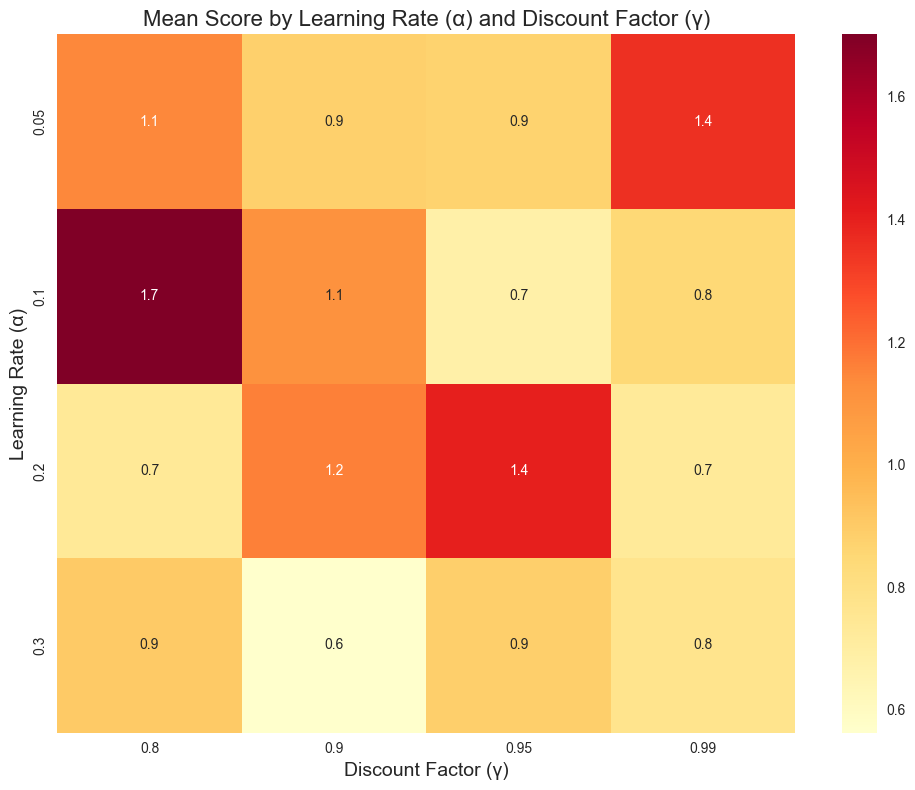

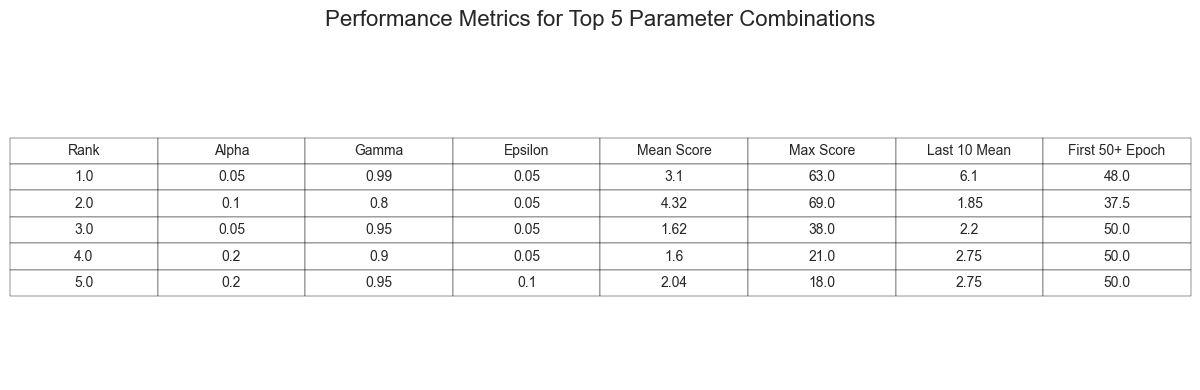

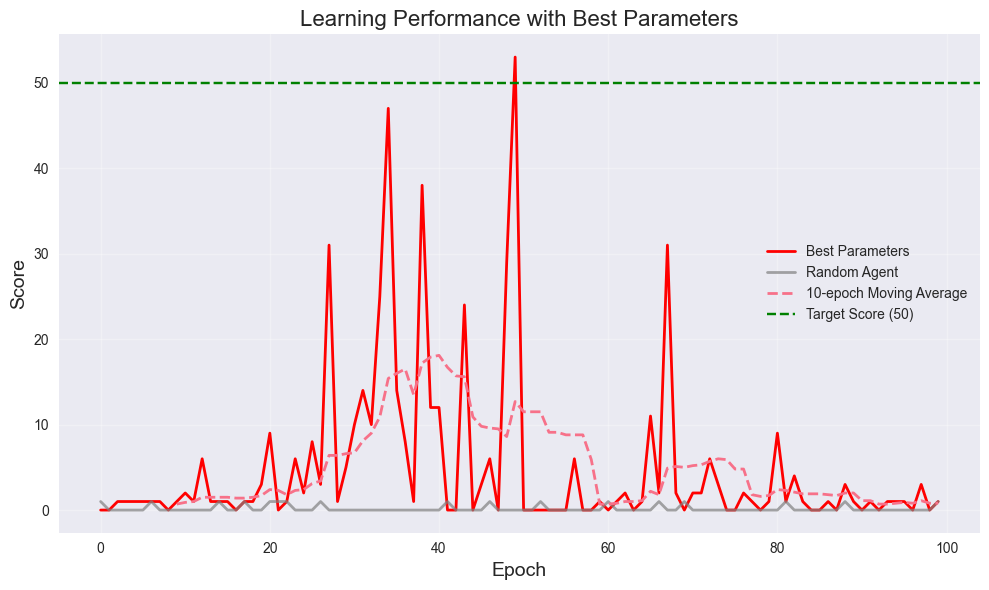


=== Performance Summary ===
Best parameters achieved:
  - Mean score: 3.10
  - Max score: 63
  - First epoch > 50: 48.0


,Rank,Alpha,Gamma,Epsilon,Mean Score,Max Score,Last 10 Mean,First 50+ Epoch
0,1,0.05,0.99,0.05,3.10,63,6.10,48.0
1,2,0.10,0.80,0.05,4.32,69,1.85,37.5
2,3,0.05,0.95,0.05,1.62,38,2.20,50.0
3,4,0.20,0.90,0.05,1.60,21,2.75,50.0
4,5,0.20,0.95,0.10,2.04,18,2.75,50.0


In [270]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def create_performance_visualizations(optimizer_results, final_history=None):
    """Create all required plots and tables for analysis"""
    
    # Set style for better-looking plots
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")
    
    # 1. Score vs Epoch plot for different parameter settings
    fig1, ax1 = plt.subplots(figsize=(12, 8))
    
    # Plot score over time for top 5 parameter combinations
    top_5_results = sorted(optimizer_results, key=lambda x: x['composite_score'], reverse=True)[:5]
    
    for i, result in enumerate(top_5_results):
        # Run one more trial with these params to get full history
        params = result['params']
        agent = Learner(**params)
        hist = []
        run_games(agent, hist, 100, 10)
        
        # Plot with different colors and labels
        label = f"α={params['alpha']}, γ={params['gamma']}, ε={params['epsilon']}"
        ax1.plot(hist, label=label, alpha=0.7, linewidth=2)
    
    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.set_ylabel('Score', fontsize=14)
    ax1.set_title('Score vs Epoch for Different Parameter Combinations', fontsize=16)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('score_vs_epoch_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Hyperparameter comparison bar plot
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    
    # Extract data for plotting
    alphas = [r['params']['alpha'] for r in top_5_results]
    gammas = [r['params']['gamma'] for r in top_5_results]
    epsilons = [r['params']['epsilon'] for r in top_5_results]
    scores = [r['metrics']['mean_score'] for r in top_5_results]
    
    # Create bar positions
    x = np.arange(len(top_5_results))
    width = 0.25
    
    # Create grouped bar chart
    ax2.bar(x - width, alphas, width, label='α (learning rate)')
    ax2.bar(x, gammas, width, label='γ (discount factor)')
    ax2.bar(x + width, epsilons, width, label='ε (exploration)')
    
    # Add mean scores as secondary y-axis
    ax2_twin = ax2.twinx()
    ax2_twin.plot(x, scores, 'ko-', linewidth=2, markersize=8, label='Mean Score')
    ax2_twin.set_ylabel('Mean Score', fontsize=12)
    
    ax2.set_xlabel('Parameter Set Rank', fontsize=14)
    ax2.set_ylabel('Parameter Value', fontsize=14)
    ax2.set_title('Top 5 Parameter Combinations and Performance', fontsize=16)
    ax2.set_xticks(x)
    ax2.set_xticklabels([f'#{i+1}' for i in range(len(top_5_results))])
    ax2.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('hyperparameter_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Parameter performance heatmap
    fig3, ax3 = plt.subplots(figsize=(10, 8))
    
    # Create a pivot table for alpha vs gamma performance
    param_data = []
    for result in optimizer_results:
        param_data.append({
            'alpha': result['params']['alpha'],
            'gamma': result['params']['gamma'],
            'score': result['metrics']['mean_score']
        })
    
    df = pd.DataFrame(param_data)
    pivot_table = df.pivot_table(values='score', index='alpha', columns='gamma', aggfunc='mean')
    
    sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax3)
    ax3.set_title('Mean Score by Learning Rate (α) and Discount Factor (γ)', fontsize=16)
    ax3.set_xlabel('Discount Factor (γ)', fontsize=14)
    ax3.set_ylabel('Learning Rate (α)', fontsize=14)
    plt.tight_layout()
    plt.savefig('parameter_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 4. Performance metrics table
    metrics_data = []
    for i, result in enumerate(top_5_results):
        row = {
            'Rank': i + 1,
            'Alpha': result['params']['alpha'],
            'Gamma': result['params']['gamma'],
            'Epsilon': result['params']['epsilon'],
            'Mean Score': result['metrics']['mean_score'],
            'Max Score': result['metrics']['max_score'],
            'Last 10 Mean': result['metrics']['last_10_mean'],
            'First 50+ Epoch': result['metrics']['first_50_idx']
        }
        metrics_data.append(row)
    
    df_metrics = pd.DataFrame(metrics_data)
    df_metrics = df_metrics.round(2)
    
    # Create table plot
    fig4, ax4 = plt.subplots(figsize=(12, 4))
    ax4.axis('tight')
    ax4.axis('off')
    table = ax4.table(cellText=df_metrics.values, colLabels=df_metrics.columns, 
                     cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    plt.title('Performance Metrics for Top 5 Parameter Combinations', fontsize=16, pad=20)
    plt.tight_layout()
    plt.savefig('performance_table.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 5. Learning curve comparison
    if final_history is not None:
        fig5, ax5 = plt.subplots(figsize=(10, 6))
        
        # Plot final training with best parameters
        ax5.plot(final_history, label='Best Parameters', linewidth=2, color='red')
        
        # Plot random agent for comparison
        random_agent = RandomJumper()
        random_hist = []
        run_games(random_agent, random_hist, 100, 10)
        ax5.plot(random_hist, label='Random Agent', linewidth=2, color='gray', alpha=0.7)
        
        # Add moving average
        window = 10
        ma = np.convolve(final_history, np.ones(window)/window, mode='valid')
        ax5.plot(range(window-1, len(final_history)), ma, 
                 label=f'{window}-epoch Moving Average', linewidth=2, linestyle='--')
        
        # Add threshold line
        ax5.axhline(y=50, color='green', linestyle='--', label='Target Score (50)')
        
        ax5.set_xlabel('Epoch', fontsize=14)
        ax5.set_ylabel('Score', fontsize=14)
        ax5.set_title('Learning Performance with Best Parameters', fontsize=16)
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('final_learning_curve.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # Print summary statistics
    print("\n=== Performance Summary ===")
    print(f"Best parameters achieved:")
    print(f"  - Mean score: {top_5_results[0]['metrics']['mean_score']:.2f}")
    print(f"  - Max score: {top_5_results[0]['metrics']['max_score']}")
    print(f"  - First epoch > 50: {top_5_results[0]['metrics']['first_50_idx']}")
    
    return df_metrics

# Usage example:
# After running the hyperparameter optimization
optimizer = HyperparameterOptimizer()
best_params, results = optimizer.grid_search(n_trials_per_config=2, n_episodes_per_trial=50)

# Create visualizations
create_performance_visualizations(results, final_history=hist)